## IMPORTS

In [1]:
import cv2
import numpy as np
import os
import time
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

## LOADING YOLO FILES AND SAVING THEIR PATHES

In [2]:
config_path = os.path.join("yolo","yolov3.cfg")
weights_path = os.path.join("yolo","yolov3.weights")
labels_path = os.path.join("yolo","coco.names")

print('Yolo config path: ',config_path)
print('Weigths file path: ',weights_path)
print('labels file path: ',labels_path)

Yolo config path:  yolo/yolov3.cfg
Weigths file path:  yolo/yolov3.weights
labels file path:  yolo/coco.names


In [3]:
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
names = net.getLayerNames()
layers_names = [names[i - 1] for i in net.getUnconnectedOutLayers()]
labels = open(labels_path).read().strip().split('\n')

print('Layers names' , layers_names)

Layers names ['yolo_82', 'yolo_94', 'yolo_106']


## ADDING A TEST IMAGE

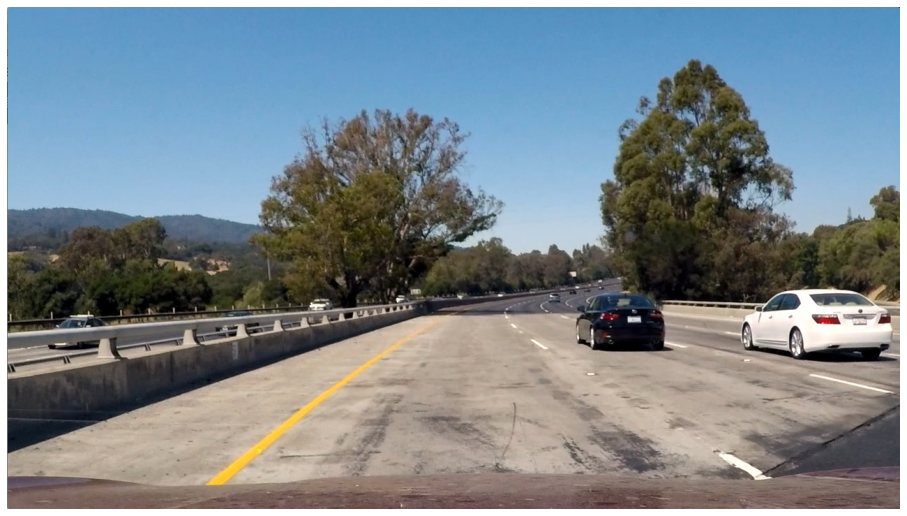

In [4]:
image_path = os.path.join("test_data","test1.jpg")
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(H,W) = img.shape[:2]

plt.figure(figsize = (16,16))
plt.axis('off')
plt.imshow(img)


## Resizing image 

In [ ]:
blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), crop=False, swapRB = False)
net.setInput(blob)
start_t = time.time()
layers_output = net.forward(layers_names)

print("Yolo V3 took {}".format(time.time() - start_t))

## Pipline

In [ ]:
boxes = []
confidences = []
classIDs = []

In [ ]:
for output in layers_output:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        
        if(confidence > 0.85):
            box = detection [:4] *np.array([W, H, W, H])
            bx, by, bw, bh = box.astype('int')
            
            x = int(bx - (bw / 2))
            y = int(by - (bh / 2))
            
            boxes.append([x, y, int(bw), int(bh)])
            confidences.append(confidence)
            classIDs.append(classID)

In [ ]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)
for i in idxs.flatten():
    (x,y) = [boxes[i][0], boxes[i][1]]
    (w, h) = [boxes[i][2], boxes[i][3]]
    
    cv2.rectangle(img, (x,y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(img, "{}: {}".format(labels[classIDs[i]],confidences[i]), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),2)
    
    
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)

# IMAGE PROCESS TO DETECT CARS

In [5]:
def process_img(img):
    blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), crop=False, swapRB = False)
    net.setInput(blob)
    layers_output = net.forward(layers_names)
    (H,W) = img.shape[:2]
    boxes = []
    confidences = []
    classIDs = []
    
    for output in layers_output:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if(confidence > 0.85):
                box = detection [:4] *np.array([W, H, W, H])
                bx, by, bw, bh = box.astype('int')

                x = int(bx - (bw / 2))
                y = int(by - (bh / 2))

                boxes.append([x, y, int(bw), int(bh)])
                confidences.append(confidence)
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)
            
    for i in idxs:
        (x,y) = [boxes[i][0], boxes[i][1]]
        (w, h) = [boxes[i][2], boxes[i][3]]

        cv2.rectangle(img, (x,y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(img, "{}: {}".format(labels[classIDs[i]],confidences[i]), (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),2)

    return img

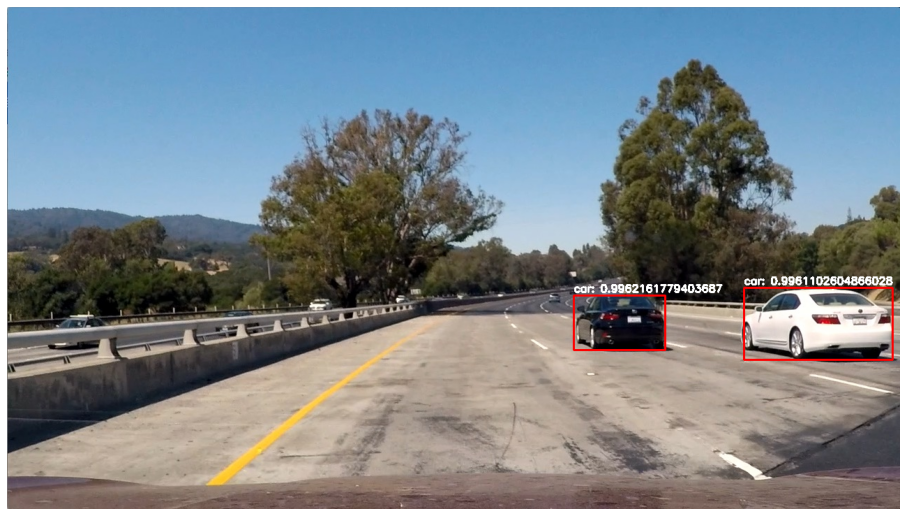

In [6]:
img = process_img(img)

plt.figure(figsize = (16, 16))
plt.axis('off')
plt.imshow(img)

# TESTING ON A VIDEO

In [7]:
input_vid = 'test_data/test_video.mp4'
output_vid = 'test_video_result.mp4'

clip1 = VideoFileClip(input_vid)
project_video_res = output_vid
project_video_clip = clip1.fl_image(process_img)
project_video_clip.write_videofile(project_video_res, audio=False)

Moviepy - Building video test_video_result.mp4.
Moviepy - Writing video test_video_result.mp4



Moviepy - Done !
Moviepy - video ready test_video_result.mp4
